In [1]:
from qampy import signals,impairments,helpers,equalisation,io,filtering,phaserec
from qampy.core import impairments as impair
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# plot signal spectrum
def plot_spec(sig):
    mysig = atleast_2d(sig)
    figure(figsize=(6,6))
    faxis=fftfreq(mysig.shape[1],1/2)
    psd = 20*log10(abs(fft.fft(mysig[0])))
    plot(faxis,psd-psd.max())
    xlabel("Normalized Frequency")
    ylabel("Relative Power")
    title("Signal spectrum")

# plot 1-D signal
def plot_1d(mysig):
    figure(figsize=(6,6))
    plot(mysig.real.flatten(),mysig.imag.flatten(),'b.')
    axis("square")
    # xticks([])
    # yticks([])
    # axis([-1.5,1.5,-1.5,1.5])
    title("Complete Frame")
    show()

# Data generation

Generate payload data (Simulate the symbol generated in Mechine learning Network)

In [3]:
M = 64                  # modulation format
pilot_seq_len = 1024    # pilot squence length, notice:phase pilots are not included 
pilot_ins_rat = 32      # i.e. for every 32 symbol, one phase pilot symbol is inserted 
N = 2**16               # total sequence length (Sequenc pilot + phase pilot + payload)
nmodes = 2              # number of polarization mode
fb = 40e9               # symbol rate
N_pl = int( (N-pilot_seq_len)*(pilot_ins_rat-1)/pilot_ins_rat )  # payload sequence length

sig_payload = signals.SignalQAMGrayCoded(M,N_pl,nmodes=nmodes,fb=fb)

<span style='background :yellow' > Sig_payload_arr: payload array that should be generated in ML netwrok </span>

In [4]:
sig_payload_arr = np.array(sig_payload)

In [5]:
sig_payload_obj = sig_payload.recreate_from_np_array(sig_payload_arr)

#### Generate pilot signal obejct (with pilot symbol) and import payload into the obejct

payload data will be repeated and imorted to 2-frame

In [6]:
pilot_sig = signals.SignalWithPilots(M, N, pilot_seq_len, pilot_ins_rat, nmodes=nmodes, Mpilots=4, nframes=2, fb=fb)
pilot_sig_pl = pilot_sig.from_symbol_array(sig_payload_obj, N, pilot_seq_len, pilot_ins_rat, pilots=None, nframes=2)

Matching filter (RRC filter) and oversampling

In [7]:
roll_off = 0.5   # roll-off factor of rrc filter
os_rate = 2      # over-sampling rate
pilot_sigResam = pilot_sig_pl.resample(os_rate*pilot_sig.fb, beta=roll_off)

In [8]:
delay = 10000    # delay 10000 symbol on purpose of synchronization
sig_delay = np.roll(pilot_sigResam,delay,axis=-1)

# Transmitter impairment

### Digital-to-analog converter impairment     (including quantization noise and frequency response)

#### DAC_response() input:
    input signal
    enob:    enob:effective number of bits, decides the effective resolution of dac
    cutoff:  3-dB cut-off frequency of dac

#### DAC_response() output:
    sigq:         signal after quantization
    sig_dac_out:  signal after quantization and 2-order bessel filter (frequency response of dac)
    snr_enob:     snr after adding quantization noise

In [9]:
enob = 6         
cutoff = 16e9    

if nmodes==1:  # if input signal has single polarization
    [sig_dac_out, sigq, snr_enob] = impair.sim_DAC_response(sig_delay, sig_delay.fs, enob, cutoff, quantizer_model=False)


elif nmodes==2:  # if input signal has dual polarization
    [sig_dac_out_xpol, sigq_xpol, snr_enob_xpol] = impair.sim_DAC_response(sig_delay[0], sig_delay.fs, enob, cutoff, quantizer_model=False)
    [sig_dac_out_ypol, sigq_ypol, snr_enob_ypol] = impair.sim_DAC_response(sig_delay[1], sig_delay.fs,enob, cutoff, quantizer_model=False)

### Ideal amplifier 

In [10]:
# Vpi of IQ modulator is 3.5 V
# signal output range is amplified to (-des_swing,des_swing)
des_swing = 3  

if nmodes==1:
    sig_amp_out = impair.ideal_amplifier_response(sig_dac_out, des_swing)
elif nmodes==2:
    sig_amp_out_xpol = impair.ideal_amplifier_response(sig_dac_out_xpol, des_swing)
    sig_amp_out_ypol = impair.ideal_amplifier_response(sig_dac_out_ypol, des_swing)

### IQ modulator

In [11]:
if nmodes==1:
    sig_mod_out = impair.modulator_response(sig_amp_out)
if nmodes==2:
    sig_mod_out_xpol = impair.modulator_response(sig_amp_out_xpol)
    sig_mod_out_ypol = impair.modulator_response(sig_amp_out_ypol)
    sig_mod_out = np.vstack((sig_mod_out_xpol,sig_mod_out_ypol))
    sig_mod_out = np.array(sig_mod_out)
    
sig_mod_out_obj = sig_delay.recreate_from_np_array(sig_mod_out)

# Channel impairment

Add AWGN noise to the signal and change snr

In [12]:
snr_loading = 35
sig_h = impairments.change_snr(sig_mod_out_obj,snr_loading)

# Receiver

Match filter and resampling (resample to 2 sample/symbol for equalization)

In [13]:
rxsig = sig_h.resample(2*pilot_sig.fb, beta=roll_off, renormalise=True)
rxsig = helpers.normalise_and_center(rxsig)

synchronizaton

In [14]:
rxsig.sync2frame()
print("shift factor" + str(["%.0f"%i for i in rxsig.shiftfctrs]))

shift factor['9994', '9994']


Frequency offset compensation, equalization and phase recovery

In [15]:
print("FOE" + str(["%.4f"%i for i in rxsig._foe]))
rxsig.corr_foe()
eq_sig = equalisation.pilot_equalizer(rxsig,(1e-3,1e-3),45,foe_comp=False,methods=("cma","sbd"))
cpe_sig = phaserec.pilot_cpe(eq_sig[1],N=5,use_seq=False)

FOE['0.0000', '0.0000']


Extract payload symbol from the object

In [16]:
receive_sig = cpe_sig[0]
receive_pilot = receive_sig.extract_pilots()
receive_payload = receive_sig.get_data()

Measure BER performance

In [17]:
receive_sig.cal_ber()

array([0.00650975, 0.00631507])

Plot constellation of received symbol

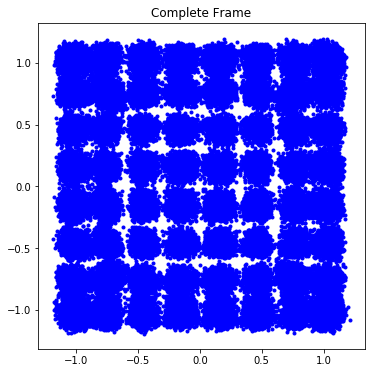

In [18]:
plot_1d(receive_sig)

Plot spectrum of transmitter output signal 

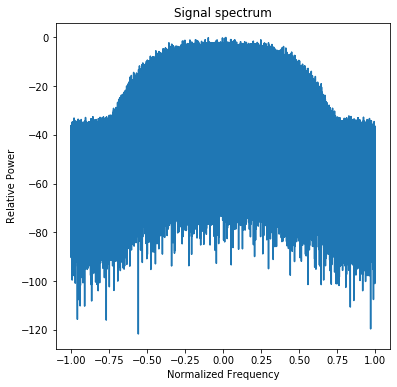

In [19]:
plot_spec(sig_mod_out)